## 3.(a)

k means can also be viewed as a special case of EM algorithm, but it assumes clusters are spherical distributed.
E step: given computed centroids(means), assign each data point label according to the closest centroid class.
M step: given the newly assigned label, compute the new centroid(mean) for each class.

In [57]:
%%html
<img src="img/3a.jpg",width=60,height=60>

Text(0, 0.5, 'Waiting')

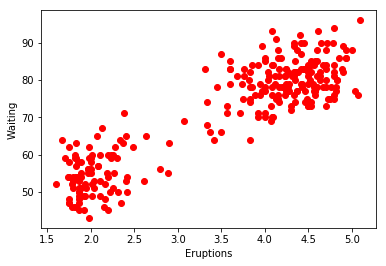

In [8]:
# 3.(b)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

data = np.loadtxt( 'faithful.dat')
eruptions = data[:, 1]
waiting = data[:, 2]
plt.plot(eruptions, waiting, 'ro')
plt.xlabel('Eruptions')
plt.ylabel('Waiting')

[[ 3.55580955 71.78646257]
 [ 3.42089459 70.02253327]]


[array([ 2.03638861, 54.47851797]), array([ 4.28966211, 79.96811687])]


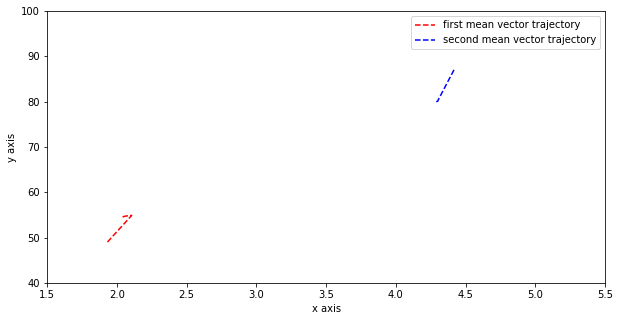

In [178]:
# 3.(c)
"""
GaussianMixture function from sklearn cannot yield step by step means vector information?
"""
from sklearn.mixture import GaussianMixture
X_train = list(zip(eruptions, waiting))
gmm = GaussianMixture(n_components=2, covariance_type='spherical', init_params='random')
gmm.fit(X_train)
print(gmm.means_)
print('\n')
# print(gmm.covariances_)

"""
Implement GMM.
- covariance matrix spherical.
- randomly initialize Gaussian params.

reference from: https://github.com/stober/gmm/blob/master/src/gmm.py
"""
import random
import numpy.linalg as la
from normal import Normal

class GMM(object):
    def __init__(self, X_train, n_comps = 2, mus = None, sigmas = None):
        if mus is not None: # generated by K-means.
            mus = mus
        else: # generated by random sampling from dataset.
            mus = random.sample(X_train.tolist(), n_comps)
        
        if sigmas is not None: # generated by K-means.
            sigmas = sigmas
        else:
            sigmas = []
            for _ in range(2):
                cov_param = np.random.random_sample() * 5 + 1 # random sample covariance lambda from (0, 5).
                sigmas.append(np.identity(2) * cov_param)
            
        self.comps = []
        self.n_comps = 2
        self.dim = 2
        self.n_data = X_train.shape[0]
        self.mu = [[] for i in range(n_comps)]
        self.mu[0] = np.array(mus[0])
        self.mu[1] = np.array(mus[1])
        self.means_over_iterations = []
        self.means_over_iterations.append([np.array(m) for m in mus])
        clusters = [[] for i in range(n_comps)]
        for d in X_train:
            i = np.argmin([la.norm(d - m) for m in mus])
            clusters[i].append(d)
        
        for i in range(n_comps):
            self.comps.append(Normal(self.dim, mu = mus[i], sigma = sigmas[i]))
            
        self.priors = np.ones(n_comps, dtype="double") / np.array([len(c) for c in clusters])
       
    def mean(self):
        """
        return current mean vector for each components.
        """
        return self.mu
    
    def loss(self, data):
        """
        return current loss. calculated by euclidean distance. 
        """
        n = data.shape[0]
        k = data.shape[1]
        means = self.mean()
        error_sum = 0
        
        responses = np.zeros((2,n)) # (2, n)

        for j in range(n):
            for i in range(k):
                responses[i,j] = self.priors[i] * self.comps[i].pdf(data[j])
        
        # compare and find the label for which has higher response.
        labels = []
        for i in range(n):
            if responses[0, i] > responses[1, i]:
                labels.append(0)
            else:
                labels.append(1)
        
        for i in range(n):
            dist = np.linalg.norm(data[i] - means[labels[i]])
            error_sum += dist
        
        return error_sum
        
    
    def em(self, data, nsteps = 100):
        if nsteps == -1:
            """
            run till converge.
            """
            epislon = 1300
            current_error = self.loss(data)
            step = 0
            while current_error > epislon:
                step += 1
                self.em(data, 1)
                current_error = self.loss(data)
            return step
        else:
            """
            run given steps.
            """
            k = self.n_comps
            d = self.dim
            n = data.shape[0]

            for l in range(nsteps):

                # E step

                responses = np.zeros((k,n))

                for j in range(n):
                    for i in range(k):
                        responses[i,j] = self.priors[i] * self.comps[i].pdf(data[j])

                responses = responses / np.sum(responses,axis=0) # normalize the weights

                # M step

                N = np.sum(responses,axis=1)

                this_two_mean = []
                for i in range(k):
                    mu = np.dot(responses[i,:],data) / N[i]
                    self.mu[i] = mu
                    this_two_mean.append(mu)
                    sigma = np.zeros((d,d))

                    for j in range(n):
                       sigma += responses[i,j] * np.outer(data[j,:] - mu, data[j,:] - mu)

                    sigma = sigma / N[i]

                    self.comps[i].update(mu,sigma) # update the normal with new parameters
                    self.priors[i] = N[i] / np.sum(N) # normalize the new priors

                self.means_over_iterations.append(this_two_mean)
    
    def get_mean_vectors(self):
        return self.means_over_iterations

"""
In such implementation.
- termination criteria is set to let the final accumulated error less than epislon.
  epislon = 1300.
- init mu vectors are chosen randomly from the existing datas.
  init sigma vectors are generated by randomly choosing a lambda from (0, 5) and form a identity matrix.
"""      
                
X_train = np.array(X_train)
gmm2 = GMM(X_train)
gmm2.em(X_train, nsteps=10)
res = gmm2.mean()
error = gmm2.loss(X_train)
print(res)
# print(error)
import pprint
means_over_iterations = gmm2.get_mean_vectors()
# pprint.pprint("overal means:")
# pprint.pprint(means_over_iterations)

first_mean = [x[0] for x in means_over_iterations]
second_mean = [x[1] for x in means_over_iterations]

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plt.plot([x[0]for x in first_mean], [x[1]for x in first_mean], 'r--', label='first mean vector trajectory')
plt.plot([x[0]for x in second_mean], [x[1]for x in second_mean], 'b--', label='second mean vector trajectory')
plt.xlabel('x axis')
plt.ylabel('y axis')
ax.set_xlim([1.5, 5.5])
ax.set_ylim([40, 100])
ax.legend(loc='best')

50


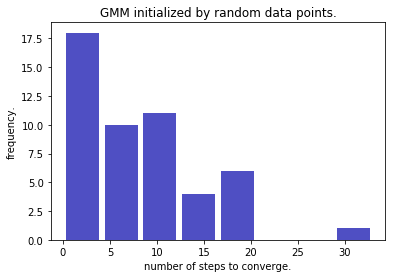

In [179]:
steps_dist = []
for _ in range(50):
    gmm3 = GMM(X_train)
    total_step = gmm3.em(X_train, nsteps=-1)
    steps_dist.append(total_step)
print(len(steps_dist))
plt.hist(x=steps_dist, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.xlabel('number of steps to converge.')
plt.ylabel('frequency.')
plt.title('GMM initialized by random data points.')
plt.show()

In [141]:
# 3. (d)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_train)
labels = kmeans.labels_ # label each data points by KNN.

new mean by maxmimum likelihood estimation on K-means.
[array([ 4.29793023, 80.28488372]), array([ 2.09433, 54.75   ])]


new variance by maxmimum likelihood estimation on K-means.
[array([[ 0.17761717,  0.76310127],
       [ 0.76310127, 31.48279475]]),
 array([[ 0.1542787,  0.9856625],
       [ 0.9856625, 34.4075   ]])]


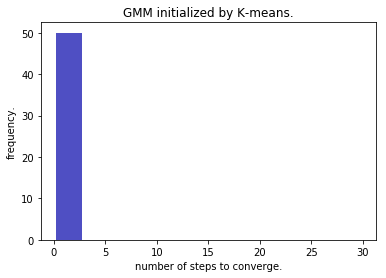

In [183]:
new_data = []
data_label_0 = X_train[labels < 1]
data_label_1 = X_train[labels > 0]
new_data.append(data_label_0)
new_data.append(data_label_1)
new_mu = []
new_sigma = []
for i in range(2):
    mu = np.sum(new_data[i], axis=0) / len(new_data[i])
    new_mu.append(mu)

for i in range(2):
    sigma = 0
    for d in range(len(new_data[i])):
        sigma += np.outer(new_data[i][d, :] - new_mu[i], new_data[i][d, :] - new_mu[i])
    sigma /= len(new_data[i])
    new_sigma.append(sigma)
    
"""
New means and variances estimated by maximum likelihood.
"""
print("new mean by maxmimum likelihood estimation on K-means.")
pprint.pprint(new_mu)
print("\n")
print("new variance by maxmimum likelihood estimation on K-means.")
pprint.pprint(new_sigma)

"""
Estimate the performance of GMM initialized by K-means.
"""
steps_dist = []
for _ in range(50):
    gmm4 = GMM(X_train, n_comps=2, mus=new_mu, sigmas=new_sigma)
    total_step = gmm4.em(X_train, nsteps=-1)
    steps_dist.append(total_step)
    
plt.hist(x=steps_dist, range=[0, 30], color='#0504aa', alpha=0.7, rwidth=0.85)
plt.xlabel('number of steps to converge.')
plt.ylabel('frequency.')
plt.title('GMM initialized by K-means.')
plt.show()

In [46]:
# 4. (a)
import numpy as np
data = np.load("mds-population.npz")
print(data['D']) # Distance matrix
print(data['population_list']) # List of populations
# print(len(data['population_list']))

from sklearn.manifold import MDS
embedding = MDS(n_components=2)
transformed = embedding.fit_transform(data['D'])
# print(transformed, transformed.shape)


[[  0.  87.  12. ... 462. 559. 553.]
 [ 87.   0.  87. ... 210. 359. 285.]
 [ 12.  87.   0. ... 317. 401. 377.]
 ...
 [462. 210. 317. ...   0. 226. 173.]
 [559. 359. 401. ... 226.   0. 127.]
 [553. 285. 377. ... 173. 127.   0.]]
[b'Bantu' b'E. Afncan' b'Nilo-Saharan' b'W. African' b'San' b'Barter'
 b'Mbuti' b'Indian' b'Iranian' b'Near Eastern' b'Uralic' b'Ainu'
 b'Japanese' b'Korean' b'Mon Khmer' b'Thai' b'Dravidian' b'Mongol Tungus'
 b'Tibetan' b'Indonesian' b'Malaysian' b'Filipino' b'N. Turkic'
 b'S. Chinese' b'Basque' b'Lapp' b'Sardinian' b'Danish' b'English'
 b'Greek' b'Italian' b'C Amerind' b'Eskimo' b'Na-Dene' b'N. American'
 b'S. American' b'Chukchi' b'Melanesian' b'Micronesian' b'Polynesian'
 b'New Guinean' b'Australian']


/usr/local/lib/python3.7/site-packages/sklearn/manifold/mds.py:421: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


## 4.(a) i.

### assumptions: 

-  We assume that we can use euclidean distances to approximate Nei's distance.
-  We assume that m dimensions yielded by MDS are suffice to simulate the original data relations.
-  We also assume that the positions(coordinates) of the MDS-transformed points are't related to its original meaning, as it is subject to rotation, translation and reflection and therefore are not unique. 

### circumstances that it could fail:

When the original data are in a high dimensional space, reducing them into 2-dimensional space with MDS may not be able to correctly represent their original structure. 

### how could be measure:

We can measure the total information loss by measuring the sum difference between the predicted distances and their original distances.

total loss = np.linalg.norm(D - D') / np.linalg.norm(D)

where D represents the original dissimilarity matrix, and D' represents the computed distance matrix, where each entry represents the euclidean distance between two objects after MDS transformation. 

## 4.(a) ii.

By sorting the singular value of D in descending order, and pick a number of top singular values that would explain the most of the total variance, such as the 95% of the variance. The number of singular values being picked is the desired dimension we want to reduce to.

## 4.(a) iii.

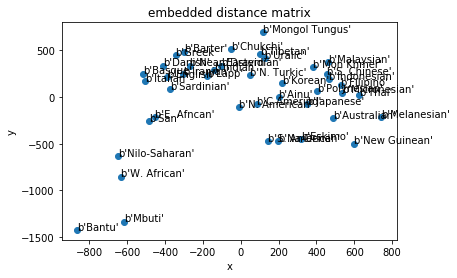

In [47]:
x = transformed[:, 0]
y = transformed[:, 1]
annotations = data['population_list']

fig, ax = plt.subplots()
ax.scatter(x, y)

for i, txt in enumerate(annotations):
    ax.annotate(txt, (x[i], y[i]))
    
plt.title('embedded distance matrix')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [48]:
# 4.(b)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(transformed)
labels = kmeans.labels_ # label each data points by KNN.
print(labels)

[0 1 0 0 1 1 0 1 1 1 1 2 2 2 2 2 1 1 1 2 2 2 1 2 1 1 1 1 1 1 1 2 2 2 2 2 1
 2 2 2 2 2]


[[  0.  87.  12. ... 462. 559. 553.]
 [ 87.   0.  87. ... 210. 359. 285.]
 [ 12.  87.   0. ... 317. 401. 377.]
 ...
 [462. 210. 317. ...   0. 226. 173.]
 [559. 359. 401. ... 226.   0. 127.]
 [553. 285. 377. ... 173. 127.   0.]]
[b'Bantu' b'E. Afncan' b'Nilo-Saharan' b'W. African' b'San' b'Barter'
 b'Mbuti' b'Indian' b'Iranian' b'Near Eastern' b'Uralic' b'Ainu'
 b'Japanese' b'Korean' b'Mon Khmer' b'Thai' b'Dravidian' b'Mongol Tungus'
 b'Tibetan' b'Indonesian' b'Malaysian' b'Filipino' b'N. Turkic'
 b'S. Chinese' b'Basque' b'Lapp' b'Sardinian' b'Danish' b'English'
 b'Greek' b'Italian' b'C Amerind' b'Eskimo' b'Na-Dene' b'N. American'
 b'S. American' b'Chukchi' b'Melanesian' b'Micronesian' b'Polynesian'
 b'New Guinean' b'Australian']


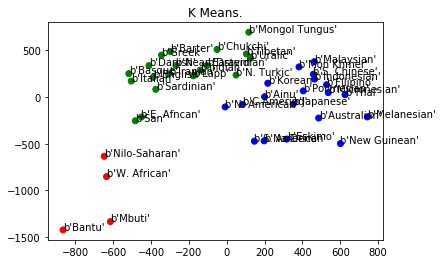

In [49]:
x = transformed[:, 0]
y = transformed[:, 1]
colors = []
for l in labels:
    if l == 0:
        colors.append('red')
    elif l == 1:
        colors.append('green')
    else:
        colors.append('blue')

fig, ax = plt.subplots()
ax.scatter(x, y, color=colors)
for i, txt in enumerate(annotations):
    ax.annotate(txt, (x[i], y[i]))
plt.title("K Means.")
    
print(data['D']) # Distance matrix
print(data['population_list']) # List of populations

I do not agree with the resulting clustering, as we can see from the original disimilarity map where Afncan and Saharan have a low dissimilarity score which means they are more similar than with other points. However, in the resulting clustering, it classifies them into two different groups. As K-means performs on comparing euclidean distances with hard threshold, it provides little explanations on the data points that lie on the edge of decision boundary. 

/usr/local/Cellar/ipython/7.1.1/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


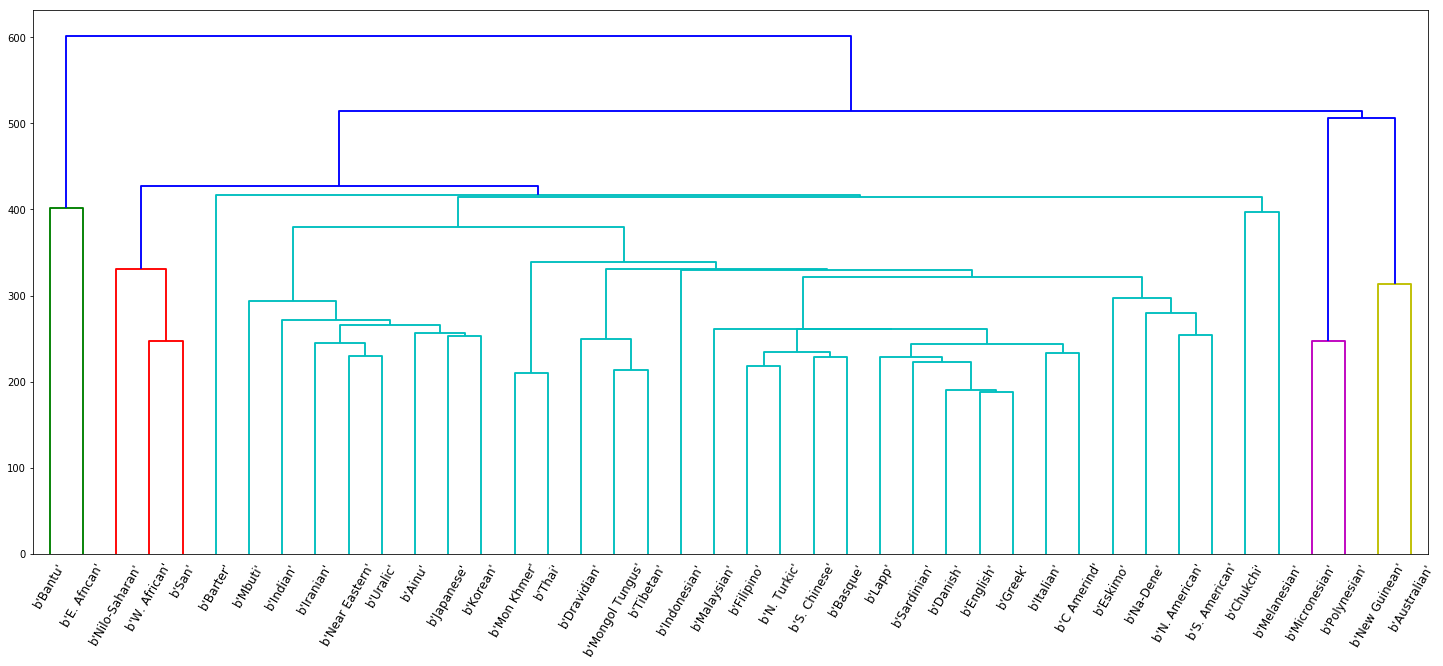

In [54]:
# 4.(c)
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
Z = linkage(data['D'])
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)
labels = data['population_list']
temp = {dn["leaves"][ii]: labels[ii] for ii in range(len(dn["leaves"]))}
def llf(xx):
    return "{}".format(temp[xx])

new_dn = dendrogram(Z, leaf_label_func=llf, leaf_rotation=60., leaf_font_size=12.)
plt.show()

In [51]:
clusters = fcluster(Z, 510, criterion='distance')
print(clusters)

[1 3 3 3 3 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2]


Text(0.5, 1.0, 'Hierachy Clustering.')

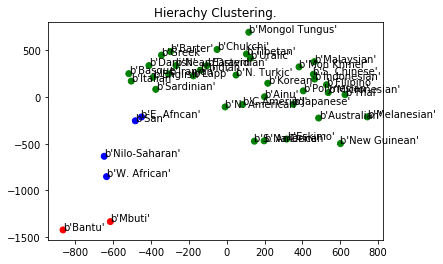

In [55]:
x = transformed[:, 0]
y = transformed[:, 1]
colors = []
for l in clusters:
    if l == 1:
        colors.append('red')
    elif l == 2:
        colors.append('green')
    else:
        colors.append('blue')

fig, ax = plt.subplots()
ax.scatter(x, y, color=colors)
for i, txt in enumerate(annotations):
    ax.annotate(txt, (x[i], y[i]))
plt.title("Hierachy Clustering.")

# print(data['D']) # Distance matrix
# print(data['population_list']) # List of populations

the clustering result I obtain using hierarchy clustering performs worse than the k-means algorithm.

[[  0.  87.  12. ... 462. 559. 553.]
 [ 87.   0.  87. ... 210. 359. 285.]
 [ 12.  87.   0. ... 317. 401. 377.]
 ...
 [462. 210. 317. ...   0. 226. 173.]
 [559. 359. 401. ... 226.   0. 127.]
 [553. 285. 377. ... 173. 127.   0.]]


Text(0.5, 1.0, 'K Medoid.')

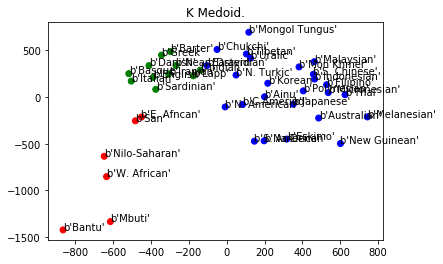

In [56]:
# 4.(d)
import kmedoids
"""
Reference: https://github.com/letiantian/kmedoids
"""
# data = np.array(data['D'])
print(data['D'])
M, C = kmedoids.kMedoids(data['D'], 3)

# print('medoids:')
# for point_idx in M:
#     print( transformed[point_idx] )

# print('')
# print('clustering result:')
# for label in C:
#     for point_idx in C[label]:
#         print('label {0}:　{1}'.format(label, transformed[point_idx]))
        
x = transformed[:, 0]
y = transformed[:, 1]
colors = [0] * len(x)
for label in C:
    for point_idx in C[label]:
        if label == 0:
            color = 'red'
        elif label == 1:
            color = 'green'
        else:
            color = 'blue'
        colors[point_idx] = color

fig, ax = plt.subplots()
ax.scatter(x, y, color=colors)
for i, txt in enumerate(annotations):
    ax.annotate(txt, (x[i], y[i]))
plt.title("K Medoid.")

From observation, there is no significant difference between the clusters generated by K-means and K-medoids.